# Collaboration and Competition

---

In this environment, two agents control rackets collabortate and compete to play tennis. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play, as such playing as long as possible in an episode. 

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

The task is episodic, and in order to solve the environment, both agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents).

### Model and Architecture

DDPG algorithm is adopted for this projecrt as it is found to work very well with continuous action space and state space. DDPG is a model-free policy-based reinforcement learning algorithm where agent learns by observing state spaces with no prior knowledge of environment dynamics. Learning improves by using policy gradient optimization algorithm. Replay memory is adopted to store and recall experience tuples. Target network is updated using soft updates with tau set at 1e-3.

DDPG is one of the known Actor-Critic models. Actor is policy-based where learning is expected to be inefficient (taking a while to converge) with high variance. Whereas Critic is value-based and is expected to be high bias. The collaboration of Actor and Critic compliment each other while overcoming their shortcomings. 

The Actor model is a neural network with 3 fully connected layers with features 24 > 400 > 300 > 2  
Tanh is used in the final layer that maps states to actions. Batch normalization is used for mini batch training. 
The Critic model is similar to Actor model except the final layer maps states and actions to Q-values.

#### The hyperparameters of the model are set as: 

1. Replay buffer size: BUFFER_SIZE = int(1e6)    
2. Minibatch size: BATCH_SIZE = 128 
3. Discount factor: GAMMA = 0.99
6. Soft update of target parameters: TAU = 1e-3  
4. Learning rate of the actor: LR_ACTOR = 5e-5         
5. Learning rate of the critic: LR_CRITIC = 6e-5   
7. L2 weight decay: WEIGHT_DECAY = 0.0001       

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import time
from datetime import datetime, timedelta
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from ddpg_agent import Agent

#### Define global parameters

In [2]:
STORE_MODELS = True # False # True - Turn it on when you are ready to do the calibration training

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.09000000171363354
Score (max over agents) from episode 4: 0.10000000149011612
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
agents = Agent(state_size=state_size, 
              action_size=action_size,
              num_agents=num_agents, 
              random_seed=0)
print(agents.actor_local)
print(agents.critic_local)

Actor(
  (fc1): Linear(in_features=24, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=2, bias=True)
)
Critic(
  (fcs1): Linear(in_features=24, out_features=400, bias=True)
  (fc2): Linear(in_features=402, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


In [7]:
def ddpg(n_episodes=5000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    avg_score_list = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agents.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            action = agents.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agents.step(state, action, rewards, next_state, dones)
            state = next_state
            score += rewards
            if np.any(dones):
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        avg_score = np.mean(scores_deque)
        avg_score_list.append(avg_score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.3f}'.\
              format(i_episode, avg_score, np.mean(score)), end="")      
        if i_episode % 50 == 0 or avg_score > 0.5:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth') 
            if avg_score > 0.5:
                print('\nEnvironment solved in {:d} episodes!'.format(i_episode))
                break
        
    return scores, avg_score_list

#### Batch size = 256  <br/> Learning rate of the actor = 6e-5  <br/> Learning rate of the critic = 5e-5        

In [8]:
scores, avg_score_list = ddpg()

C:\Users\jieww\Anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 50	Average Score: -0.00	Score: -0.005
Episode 100	Average Score: -0.00	Score: -0.005
Episode 150	Average Score: -0.00	Score: -0.005
Episode 200	Average Score: -0.00	Score: -0.005
Episode 250	Average Score: -0.00	Score: -0.005
Episode 300	Average Score: -0.00	Score: -0.005
Episode 350	Average Score: -0.00	Score: -0.005
Episode 400	Average Score: -0.00	Score: -0.005
Episode 450	Average Score: -0.00	Score: -0.005
Episode 500	Average Score: -0.00	Score: -0.005
Episode 550	Average Score: -0.00	Score: -0.005
Episode 600	Average Score: -0.00	Score: -0.005
Episode 650	Average Score: -0.00	Score: -0.005
Episode 700	Average Score: -0.00	Score: -0.005
Episode 750	Average Score: -0.00	Score: 0.1455
Episode 800	Average Score: 0.01	Score: -0.005
Episode 850	Average Score: 0.01	Score: -0.005
Episode 900	Average Score: -0.00	Score: -0.005
Episode 950	Average Score: -0.00	Score: -0.005
Episode 1000	Average Score: -0.00	Score: -0.005
Episode 1050	Average Score: -0.00	Score: -0.005
Episode 1100	A

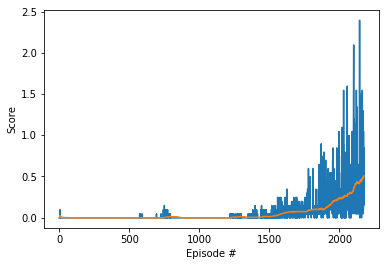

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(avg_score_list)+1), avg_score_list)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Batch size = 128  <br/> Learning rate of the actor = 6e-5  <br/> Learning rate of the critic = 5e-5        

In [8]:
scores, avg_score_list = ddpg()

C:\Users\jieww\Anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 50	Average Score: -0.00	Score: -0.005
Episode 100	Average Score: -0.00	Score: -0.005
Episode 150	Average Score: -0.00	Score: -0.005
Episode 200	Average Score: -0.00	Score: -0.005
Episode 250	Average Score: -0.00	Score: -0.005
Episode 300	Average Score: -0.00	Score: -0.005
Episode 350	Average Score: -0.00	Score: -0.005
Episode 400	Average Score: -0.00	Score: -0.005
Episode 450	Average Score: -0.00	Score: -0.005
Episode 500	Average Score: -0.00	Score: -0.005
Episode 550	Average Score: -0.00	Score: -0.005
Episode 600	Average Score: -0.00	Score: -0.005
Episode 650	Average Score: -0.00	Score: -0.005
Episode 700	Average Score: -0.00	Score: -0.005
Episode 750	Average Score: -0.00	Score: -0.005
Episode 800	Average Score: -0.00	Score: -0.005
Episode 850	Average Score: -0.00	Score: -0.005
Episode 900	Average Score: -0.00	Score: -0.005
Episode 950	Average Score: 0.01	Score: -0.0055
Episode 1000	Average Score: 0.01	Score: -0.005
Episode 1050	Average Score: 0.02	Score: -0.005
Episode 1100	A

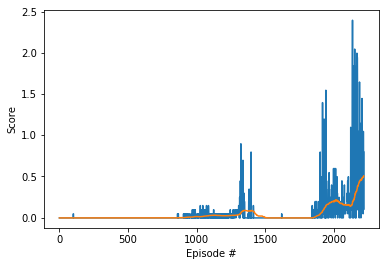

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(avg_score_list)+1), avg_score_list)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
env.close()

### 5. Improvement suggestion

I will consider implementing Prioritized Experience Replay using a special data structure Sum Tree as describe in [Prioritized Experience Replay (PER) implementation in PyTorch](https://github.com/rlcode/per) for similar game playing agent (such as soccer playing agents with more playing agents) and other more practical applications such as a trading agent in a much more complex environment. 

As recommended by OpenAI, Proximal Policy Optimization (PPO) performs comparably if not better than state-of-the-art approaches while being much simpler to implement and tune. Due to its ease of use and good performance, this algorithm may converge faster and shall be able to handle more complicated multi-agent in a more complex environment tasks. 